In [64]:
import numpy as np
from sklearn.datasets import load_diabetes
from graphviz import Digraph
import matplotlib.pyplot as plt

In [65]:
data = load_diabetes()
X = data.data
y = data.target

# Decision Tree regressor class

In [66]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class DecisionTreeRegressor:
    def __init__(self, max_depth = 4, min_sample_split = 40):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.root = None

    def best_split(self, X, y):
        n_features = X.shape[1]

        best_var_red = -float('inf')
        best_feature = None
        best_threshold = None

        y_var = np.var(y)* len(y)

        for feature in range(n_features):
            sorted_idx = np.argsort(X[:, feature])
            X_sorted = X[sorted_idx, feature]
            y_sorted = y[sorted_idx]

            total_sum = np.sum(y_sorted)
            total_sq_sum = np.sum(y_sorted ** 2)

            n = len(y_sorted)

            left_sum = 0
            left_sq_sum = 0

            for i in range(n-1):
                yi = y_sorted[i]
                left_sum += yi
                left_sq_sum += yi ** 2

                right_sum = total_sum - left_sum
                right_sq_sum = total_sq_sum - left_sq_sum

                # variance = SS/n - (S/n)**2
                left_n = i + 1
                right_n = n - left_n

                if left_n == 0 or right_n == 0:
                    continue

                if X_sorted[i] == X_sorted[i + 1]:
                    continue

                left_var = (left_sq_sum / left_n) - (left_sum / left_n)**2
                right_var = (right_sq_sum / right_n) - (right_sum / right_n)**2

                var_reduction = y_var - ((left_var * left_n) + (right_var * right_n))
                thres = (X_sorted[i] + X_sorted[i + 1]) / 2
                if var_reduction > best_var_red:
                    best_var_red = var_reduction
                    best_feature = feature
                    best_threshold = thres

        return best_var_red, best_feature, best_threshold


    def build_tree(self, X, y, depth = 0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth) or (n_samples < self.min_sample_split) or np.var(y) == 0:
            return Node(value = np.mean(y))

        var_red, feature, threshold = self.best_split(X,y)
        if feature is None:
            return Node(value = np.mean(y))
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left = self.build_tree(X[left_mask] , y[left_mask] , depth + 1)
        right = self.build_tree(X[right_mask] , y[right_mask] , depth + 1)

        return Node(
            feature = feature,
            threshold = threshold,
            left = left,
            right = right
        )

    def plot_tree(self,node ,dot = None, counter = [0]):
        if dot is None:
            dot = Digraph()
            dot.attr('node', shape = 'box')

        counter_id = str(counter[0])
        counter[0] += 1

        if node.value is not None:
                dot.node(counter_id, f'Leaf \n Value: {node.value :.2f}')
        else:
            dot.node(counter_id, f'X[{node.feature}] <= {node.threshold}')
            left_id = self.plot_tree(node.left, dot, counter)
            right_id = self.plot_tree(node.right, dot, counter)

            dot.edge(counter_id, left_id, label = 'True')
            dot.edge(counter_id, right_id, label = 'False')

        return counter_id

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])



# GradientBoostingRegressor class

In [67]:
class myGradientBoostingRegressor:
    def __init__(self, n_iter, learning_rate, max_depth, min_sample_split):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.init_val = None
        self.trees = []
        self.loss_history = []

    def fit(self, X, y):
        self.init_val = y.mean()
        y_pred = np.full_like(y, fill_value = self.init_val, dtype = float)

        patience = 10
        epochs_without_improvement = 0
        min_delta = 1
        for _ in range(self.n_iter):
            residual = y - y_pred
            loss = np.mean(residual ** 2)

            if self.loss_history:
                 if self.loss_history[-1] - loss > min_delta:
                    epochs_without_improvement = 0
                 else:
                    epochs_without_improvement += 1
            else:
                epochs_without_improvement = 0

            self.loss_history.append(loss)

            if epochs_without_improvement >= patience:
                break


            tree = DecisionTreeRegressor(
                max_depth = self.max_depth,
                min_sample_split = self.min_sample_split
            )

            tree.fit(X, residual)

            # value update
            y_pred += self.learning_rate * tree.predict(X)
            self.trees.append(tree)




    def predict(self, X):
        y_pred = np.full(X.shape[0] , self.init_val)

        for tree in self.trees:
            y_pred +=  self.learning_rate * tree.predict(X)

        return y_pred


# utility functions

In [68]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Model execution

In [69]:
train_X, train_y, test_X, test_y = train_test_split(X, y , 0.6 , shuffle = True, seed = 1)
model = myGradientBoostingRegressor(n_iter = 500, learning_rate = 0.01, max_depth = 3 , min_sample_split = 30)
model.fit(train_X, train_y)
y_pred = model.predict(test_X)

# Loss curve

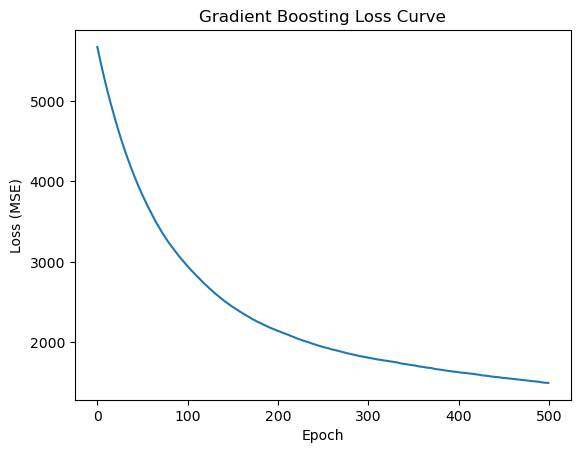

In [70]:
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Gradient Boosting Loss Curve")
plt.show()

# R2_Score comparision with standared sklearn GradientBoostingRegressor

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

sk_model = GradientBoostingRegressor(n_estimators = 500 , learning_rate= 0.01, max_depth = 3, min_samples_split=30, random_state = 1)
sk_model.fit(train_X, train_y)
sk_pred = sk_model.predict(test_X)
print('sklearn r2_score: ',r2_score(test_y, sk_pred))
print('my r2_score: ', r2_score(test_y, y_pred))

sklearn r2_score:  0.501180346171562
my r2_score:  0.5017176947503565
